<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/marcoteran/artificialintelligence/blob/master/notebooks/01_machinelearning/taller_artificialintelligence_knn.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"></a>

# Taller: Clasificación no lineal, complejidad y sobreajuste
## Inteligencia Artificial

**Name:** Marco Teran **E-mail:** marco.tulio.teran@gmail.com,
[Website](http://marcoteran.github.io/),
[Github](https://github.com/marcoteran),
[LinkedIn](https://www.linkedin.com/in/marcoteran/).
___

Siguiendo con el conjunto de datos **Wine**.

# Realice:

* Cargue el conjunto de datos **Wine**.
* Genere una partición estratificada 70-30 sobre el conjunto de datos.
* Genere una gráfica de barras en Pandas que verifique que las particiones de entrenamiento y prueba tengan la misma distribución de clases.

## Explorando la complejidad usando `KNearestNeighbor`
* Entrene un modelo `KNearestNeighbor`. Use los siguientes valores para evaluar la complejidad:
    * $[1, 2, 3, \dots, 20]$
    * Grafique los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.
* Construya un conjunto de datos usando las características `Proline` contra `Flavonoids`. 
    * Use la partición 70-30 definida al inicio
    * Usando `KNearestNeighbor`, determine el número subóptimo de k-vecinos usando evaluación de la complejidad. Use los mismos valores de $k$: $[1, 2, 3, \dots, 20]$
    * Grafique la superficie de decisión contra los ejemplos de test.
    * Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

___

In [169]:
!mkdir -p data/
!cd data/
!wget https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/data/wine.data.txt -P data/
!ls

--2021-11-03 01:40:28--  https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/data/wine.data.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcoteran/artificialintelligence/master/notebooks/01_machinelearnig/data/wine.data.txt [following]
--2021-11-03 01:40:28--  https://raw.githubusercontent.com/marcoteran/artificialintelligence/master/notebooks/01_machinelearnig/data/wine.data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10925 (11K) [text/plain]
Saving to: ‘data/wine.data.txt.6’

wine.data.txt.6     100%[===================>]  10.67K  --.-KB/

In [170]:
import pandas as pd


In [171]:
winedata_df=pd.read_csv("/content/data/wine.data.txt")

In [172]:
winedata_df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [173]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_moons

In [174]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color.reshape(1,-1),
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

Procesamiento de Datos

In [175]:
wine_labels=winedata_df["Class"]

In [176]:
winedata_df.drop("Class",axis=1,inplace=True)

In [177]:
winedata_df.head()

,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [178]:
X=np.array(winedata_df)
y=np.array(wine_labels)

In [179]:
X_PF=X[:,[6,12]]

Training


In [180]:
from sklearn.neighbors import KNeighborsClassifier

In [181]:
from sklearn.model_selection import train_test_split

In [182]:
X_train, X_test, y_train,y_test = train_test_split(X_PF, y,
                                                   test_size=0.3,
                                                   stratify=y)

In [183]:
k_values= list(range(1,21))
print(k_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [184]:
train_error = []
generalization_error = []

# Utilizar un for
for nn in k_values:
  knn=KNeighborsClassifier(n_neighbors=nn)
  knn.fit(X_train,y_train)
  train_error.append(1-knn.score(X_train,y_train))
  generalization_error.append(1-knn.score(X_test,y_test))

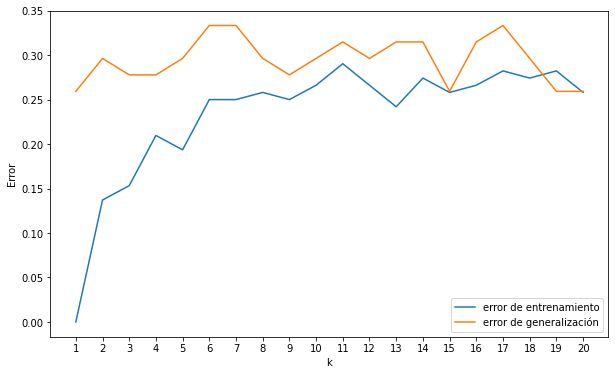

In [185]:
# Visualizar las curvas de aprendizaje
pl.figure(figsize=(10,6))

pl.plot(k_values, train_error, label='error de entrenamiento')
pl.plot(k_values, generalization_error, label='error de generalización')
pl.xticks(k_values)
pl.xlabel('k')
pl.ylabel('Error')
pl.legend()


In [187]:
knn_opt=KNeighborsClassifier(n_neighbors=15)
knn_opt.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

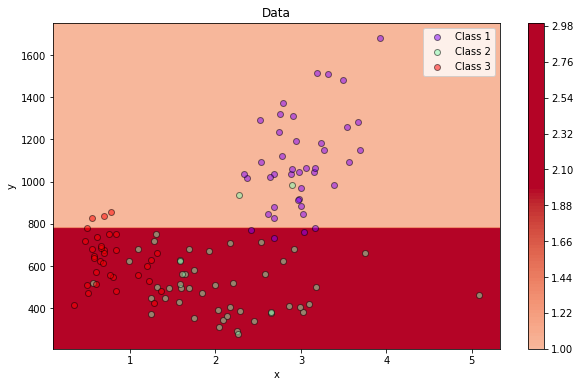

In [188]:
# Dibujar superficie de decición con los datos de entrenamiento
pl.figure(figsize=(10,6))
plot_decision_region(X_train, gen_pred_fun(knn_opt))
plot_data(X_train, y_train)

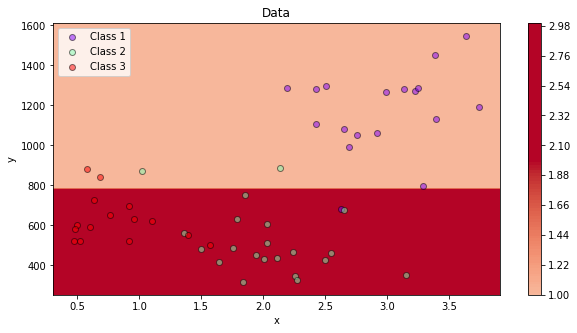

In [189]:
pl.figure(figsize=(10,5))
plot_decision_region(X_test,gen_pred_fun(knn_opt))
plot_data(X_test,y_test)

In [190]:
print("Error de Generalizacion: {}".format(1-knn.score(X_test,y_test)))

Error de Generalizacion: 0.2592592592592593


KNN con 13 Caracteristicas


In [191]:
X=np.array(winedata_df)
y=np.array(wine_labels)

In [192]:
X_train1, X_test1, y_train1,y_test1 = train_test_split(X, y,
                                                   test_size=0.3,
                                                   stratify=y)

In [193]:
k_values= list(range(1,21))
print(k_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [194]:
train_error1 = []
generalization_error1 = []

# Utilizar un for
for nn in k_values:
  knn=KNeighborsClassifier(n_neighbors=nn)
  knn.fit(X_train1,y_train1)
  train_error1.append(1-knn.score(X_train1,y_train1))
  generalization_error1.append(1-knn.score(X_test1,y_test1))

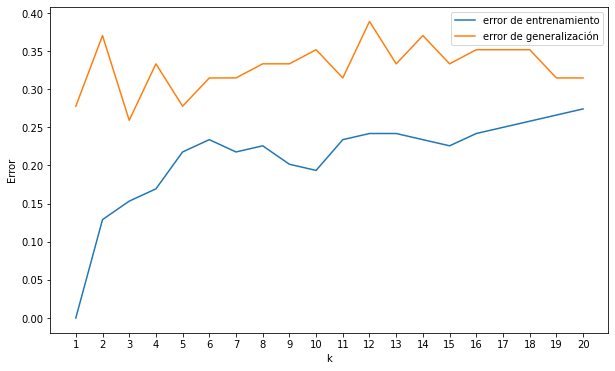

In [195]:
# Visualizar las curvas de aprendizaje
pl.figure(figsize=(10,6))

pl.plot(k_values, train_error1, label='error de entrenamiento')
pl.plot(k_values, generalization_error1, label='error de generalización')
pl.xticks(k_values)
pl.xlabel('k')
pl.ylabel('Error')
pl.legend()


In [196]:
knn_opt1=KNeighborsClassifier(n_neighbors=11)
knn_opt1.fit(X_train1,y_train1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [197]:
print("Error de Generalizacion: {}".format(1-knn.score(X_test1,y_test1)))

Error de Generalizacion: 0.31481481481481477


Conclusion: El error de generalizacion sube entre mas clases se tengan en cuenta para el entrenamiento